# Diffusion PDE

In [1]:
import numpy
from matplotlib import pyplot

$$\frac{\partial u}{\partial t}=\nu \frac{\partial^2 u}{\partial x^2}$$

Shorter notation: $u_t =\nu \cdot u_{xx}$, where $\nu$ is viscosity

Using forward scheme for time derivative (Euler) and central scheme for the spatial second-derivative.

Referring to Heiner Igel's course, when it comes to second-derivative, there are 3-point and 5-point operator for FD (see his `W2_P2` notebook). First, for the **3-point operator**:  

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu \frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

Then, for the **5-point operator**:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu \frac{\frac{-1}{12} u_{i+2}^{n}+\frac{4}{3}u_{i+1}^{n}-\frac{5}{2}u_{i}^{n}+\frac{4}{3}u_{i-1}^{n}-\frac{1}{12}u_{i-2}^{n}}{\Delta x^2}$$

Time extrapolation for **3-point operator**:

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu \Delta t}{\Delta x^2} (u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

Time extrapolation for **5-point operator**:

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu \Delta t}{\Delta x^2} (\frac{-1}{12} u_{i+2}^{n}+\frac{4}{3}u_{i+1}^{n}-\frac{5}{2}u_{i}^{n}+\frac{4}{3}u_{i-1}^{n}-\frac{1}{12}u_{i-2}^{n})$$

CFL for diffusion PDE:

$$\frac{\nu \Delta t}{\Delta x^2} \leq \frac{1}{2}$$

Make into function `diffusion_cfl`, for both 3-point and 5-point, like in another notebook we create `linear_convection_cfl` and `nonlinear_convection_cfl`. The differences are:
* Operator input is `op=3` or `op=5` (for 3-point and 5-point operator, respectively)
* Viscosity `nu` instead of speed `c`
* How `dt` is calculated from CFL, `sigma`
* Formulation of finite-difference (forward-central)

First one is without vectorization.

In [44]:
def diffusion_cfl(nx, op=3, L=2, nu=0.3, sigma=0.5, nt=25):
    # op is the number of operators (3 or 5)
    
    dx = L / (nx - 1) 
    x = numpy.linspace(0.0, L, num=nx)
    
    # calculate dt from CFL given
    dt = sigma * dx**2 / nu
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Integrate the solution in time (without vectorization).
    # 3-point or 5-point operator
    if op == 3: 
        u = u0.copy()
        for n in range(nt):
            un = u.copy()
            for i in range(1, nx-1): # Look at Heiner Igel's W2_p2 notebook
                u[i] = un[i] + nu * dt / dx**2 * (un[i + 1] - 2 * un[i] + un[i - 1])
    if op == 5: 
        u = u0.copy()
        for n in range(nt):
            un = u.copy()
            for i in range(1, nx-2): # Look at Heiner Igel's W2_p2 notebook
                u[i] = un[i] + nu * dt / dx**2 * (-1/12 * un[i + 2] + 4/3 * un[i + 1] - \
                                                  5/2 * un[i] + 4/3 * un[i - 1] - 1/12 * un[i - 2])                
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);    

Second is with vectorization.

Note about vectorization: Prof L. Barba in [this notebook](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb#Non-linear-convection) explained the vectorization using "vectorized stencil diagram" for first-derivative. I also try to understand it for second-derivative. I make the following stencil diagram for 3-point and 5-point operators, respectively.

![image](https://user-images.githubusercontent.com/51282928/100600440-ded85400-3333-11eb-9ae9-0182a444b6cc.png)

In [61]:
def diffusion_cfl(nx, op=3, L=2, nu=0.3, sigma=0.5, nt=25):
    # Vectorized version
    # op is the number of operators (3 or 5)
    
    dx = L / (nx - 1) 
    x = numpy.linspace(0.0, L, num=nx)
    
    # calculate dt from CFL given
    dt = sigma * dx**2 / nu
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Integrate the solution in time.
    # 3-point or 5-point operators
    if op == 3:
        u = u0.copy()
        for n in range(nt):
            u[1:-1] = u[1:-1] + nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])

    if op == 5:
        u = u0.copy()
        for n in range(nt):
            u[2:-2] = u[2:-2] + nu * dt / dx**2 * (-1/12 * u[4:] + 4/3 * u[3:-1] - 5/2 * u[2:-2] + 4/3 * u[1:-3] - 1/12 * u[:-4])            
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);    

### 3-point operator

Try with CFL equals 0.5 and 0.2.

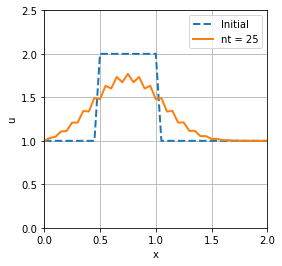

In [53]:
diffusion_cfl(41, op=3, nu=0.3, sigma=0.5, nt=25)

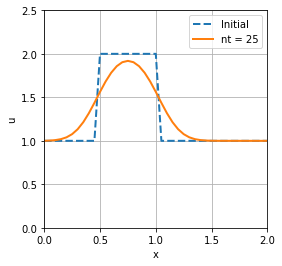

In [54]:
diffusion_cfl(41, op=3, nu=0.3, sigma=0.2, nt=25)

### 5-point operator

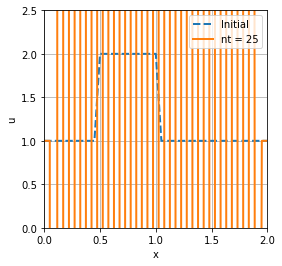

In [67]:
diffusion_cfl(41, op=5, nu=0.3, sigma=0.5, nt=25)

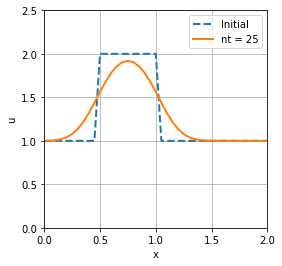

In [71]:
diffusion_cfl(41, op=5, nu=0.3, sigma=0.2, nt=25)

Observation: CFL=0.2 is always better than CFL=0.5. It's also interesting to see how 3-point FD compares to 5-point FD. In 5-point FD, CFL=0.5 makes the simulation explodes much worse than in 3-point FD.

## Producing animation

In [2]:
from matplotlib import animation
from IPython.display import HTML

In [15]:
def diffusion_mov(nx, op=3, L=2, nu=0.3, sigma=0.5, nt=25):
    dx = L / (nx - 1) 
    x = numpy.linspace(0.0, L, num=nx)
    
    # calculate dt from CFL given
    dt = sigma * dx**2 / nu
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Integrate the solution in time.
    # 3-point or 5-point operators
    u_hist = [u0.copy()]
    if op == 3:
        u = u0.copy()
        for n in range(nt):
            u[1:-1] = u[1:-1] + nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])
            u_hist.append(u.copy())

    if op == 5:
        u = u0.copy()
        for n in range(nt):
            u[2:-2] = u[2:-2] + nu * dt / dx**2 * (-1/12 * u[4:] + 4/3 * u[3:-1] - 5/2 * u[2:-2] + 4/3 * u[1:-3] - 1/12 * u[:-4])            
            u_hist.append(u.copy())
            
    return x, u0, u_hist

Simulate diffusion with 5-point operator and CFL=0.2

In [16]:
x, u0, u_hist = diffusion_mov(41, op=5, sigma=0.2)

In [17]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n])

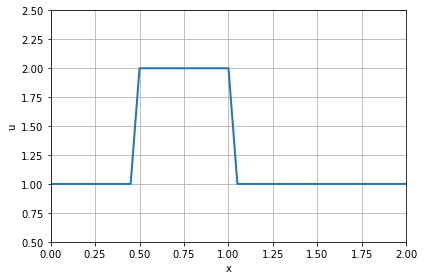

In [18]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
line = pyplot.plot(x, u0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, 2)
pyplot.ylim(0.5, 2.5)
fig.tight_layout()

In [19]:
# Create an animation.
nt = 25
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(u_hist,),
                               interval=200)

In [20]:
# Display the video.
HTML(anim.to_html5_video())